## 0. Project Planning

- goal is to learn as much as possible - this is my first time handling more complex data
- i want to combine regression and classification - regression will be your typical predicting the house sale price (which i’ll interpret as asking price - how much homes are selling for in the area). my prediction will be the predicted house’s market value - the difference between the value and the asking price is one measure of how good the deal is. i can then sort homes into underpriced, fairly priced, and overpriced. then, i can apply classification to determine whether a house has good flipping potential and is worth checking out based on factors like if it’s “underpriced”, has room for renovation, has high demand and/or low supply (if i can extract that from the data), and sales cycle length.

##### EVAL:
regression will be based simply on r2 and mean squared error.
in classification i can try to mess with slightly more complex evaluation (like confusion matrix, and precision and recall for the “high flipping potential” class).
RELEVANT METRICS:
anything that has an impact on sales price
factors that signal whether flipping potential is high or low - underpriced, fast sales cycle, supply demand mismatch (if absent, i can use houses sold in the same neighbourhood as a proxy for demand), renovation potential.

i have to be sure to explain assumptions and limitations of the dataset and why I do what I do - succinctly but clearly.

## 1. Importing Dataset & Libraries

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [251]:
#importing dataset
df = pd.read_csv('AmesHousing.csv')
pd.set_option("display.max_columns", None)   # allows you to see all columns
df.head()


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,NaN,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## 2. Exploratory Data Analysis

- get an understanding of the data 
- get an idea of what to do with certain columns

In [252]:
from sklearn.model_selection import train_test_split

#train test split to avoid any learning from the test data
X = df.drop(['PID', 'Order', 'SalePrice'], axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_train = pd.concat([X_train, y_train], axis=1)

- broad EDA

In [253]:
df.describe(include=object)

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
count,2930,2930,198,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930,1155,2930,2930,2930,2850,2850,2847,2850,2849,2930,2930,2930,2929,2930,2930,1508,2773,2771,2771,2771,2930,13,572,106,2930,2930
unique,7,2,2,4,4,3,5,3,28,9,8,5,8,6,8,16,17,4,4,5,6,5,5,4,6,6,6,5,2,5,5,8,5,6,3,5,5,3,4,4,5,10,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,2273,2918,120,1859,2633,2927,2140,2789,443,2522,2900,2425,1481,2321,2887,1026,1015,880,1799,2549,1310,1283,2616,1906,859,2499,2885,1495,2734,2682,1494,2728,744,1731,1231,2615,2665,2652,4,330,95,2536,2413


In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [255]:
df.select_dtypes(include=int).describe()

,Order,PID,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,10147.921843,6.094881,5.563140,1971.356314,1984.266553,1159.557679,335.455973,4.676792,1499.690444,1.566553,0.379522,2.854266,1.044369,6.443003,0.599317,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,845.96247,1.887308e+08,42.638025,7880.017759,1.411026,1.111537,30.245361,20.860286,391.890885,428.395715,46.310510,505.508887,0.552941,0.502629,0.827731,0.214076,1.572964,0.647921,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,1.00000,5.263011e+08,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.25000,5.284770e+08,20.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,876.250000,0.000000,0.000000,1126.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.50000,5.354536e+08,50.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,1084.000000,0.000000,0.000000,1442.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2197.75000,9.071811e+08,70.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,1384.000000,703.750000,0.000000,1742.750000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.00000,1.007100e+09,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5095.000000,2065.000000,1064.000000,5642.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [256]:
df.select_dtypes(include=object).describe().T

,count,unique,top,freq
MS Zoning,2930,7,RL,2273
Street,2930,2,Pave,2918
Alley,198,2,Grvl,120
Lot Shape,2930,4,Reg,1859
Land Contour,2930,4,Lvl,2633
Utilities,2930,3,AllPub,2927
Lot Config,2930,5,Inside,2140
Land Slope,2930,3,Gtl,2789
Neighborhood,2930,28,NAmes,443
Condition 1,2930,9,Norm,2522


- vizualizing and transforming target variable

<Axes: xlabel='SalePrice', ylabel='Count'>

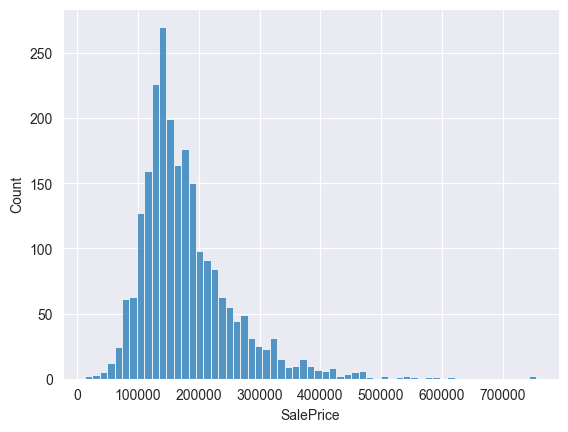

In [257]:
#vizualizing target (for the regression task)
sns.histplot(y_train)


In [258]:
#the target variable has a long right tail - we should log transform the data
df.describe()['SalePrice']

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [259]:
#log transforming it can increase model accuracy by making the effect of outliers proportional.
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

<Axes: xlabel='SalePrice', ylabel='Count'>

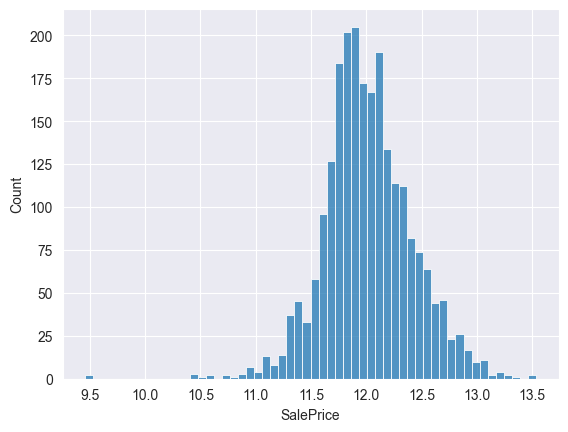

In [260]:
#a viz of the transformed target
sns.histplot(y_train_log)

In [261]:
y_train.sort_values(ascending=True)

181      12789
1553     13100
726      34900
2843     35000
2880     35311
         ...  
2450    584500
1637    591587
1063    615000
1760    745000
1767    755000
Name: SalePrice, Length: 2344, dtype: int64

In [262]:
#let's ensure all sales happened at around the same time so we don't have to adjust anything for inflation
df['Yr Sold'].value_counts()

Yr Sold
2007    694
2009    648
2006    625
2008    622
2010    341
Name: count, dtype: int64

we might have to compare only between houses sold in the same year - for example, 2008 was a year of massive crashes on the market. on the other hand though, a deal is a deal... if i don't factor it in it'll just mean that 2008 will have more good deals, which actually makes perfct sense. so i can leave it. although, maybe i should note in my final polished project that the classifier that detects houses with a high flipping potential assumes that you'll exist in similar market conditions to when the house was bought - a crash like the one in 2008 would melt your wallet.

In [263]:
#linear correlation of continuous variables with the target
df_train.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False)


SalePrice          1.000000
Overall Qual       0.795298
Gr Liv Area        0.698315
Garage Cars        0.644304
Garage Area        0.633106
Total Bsmt SF      0.612256
1st Flr SF         0.607433
Year Built         0.545409
Full Bath          0.542053
Year Remod/Add     0.517653
Garage Yr Blt      0.516211
Mas Vnr Area       0.490912
TotRms AbvGrd      0.475455
Fireplaces         0.467501
BsmtFin SF 1       0.423906
Wood Deck SF       0.333045
Lot Frontage       0.328726
Open Porch SF      0.297722
Bsmt Full Bath     0.286515
Half Bath          0.285369
2nd Flr SF         0.278977
Lot Area           0.261336
Bsmt Unf SF        0.163571
Bedroom AbvGr      0.149269
Screen Porch       0.136936
Pool Area          0.079020
3Ssn Porch         0.034845
Mo Sold            0.030714
BsmtFin SF 2       0.027205
Low Qual Fin SF   -0.016025
Misc Val          -0.017729
Bsmt Half Bath    -0.023675
Yr Sold           -0.037686
MS SubClass       -0.066351
Overall Cond      -0.104085
Kitchen AbvGr     -0

In [264]:
#let's also viz missing values
print(X_train.shape)
X_train.isna().sum().sort_values(ascending=False)

(2344, 79)


Pool QC            2332
Misc Feature       2250
Alley              2182
Fence              1874
Mas Vnr Type       1426
Fireplace Qu       1144
Lot Frontage        393
Garage Yr Blt       122
Garage Qual         122
Garage Cond         122
Garage Finish       122
Garage Type         120
Bsmt Exposure        63
BsmtFin Type 2       62
BsmtFin Type 1       61
Bsmt Cond            61
Bsmt Qual            61
Mas Vnr Area         19
Bsmt Full Bath        1
BsmtFin SF 2          1
Bsmt Unf SF           1
Total Bsmt SF         1
BsmtFin SF 1          1
Bsmt Half Bath        1
Garage Cars           1
Garage Area           1
Full Bath             0
Half Bath             0
Bedroom AbvGr         0
Kitchen AbvGr         0
Kitchen Qual          0
TotRms AbvGrd         0
Functional            0
Sale Type             0
Yr Sold               0
Mo Sold               0
Misc Val              0
Pool Area             0
Screen Porch          0
3Ssn Porch            0
Enclosed Porch        0
Open Porch SF   

## 3. Data Cleaning

### 3.1 Inspecting Missing Values

In [265]:
missing = X_train.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(X_train)) * 100
types = X_train.dtypes
unique_vals = X_train.nunique()

summary = pd.concat([missing, missing_percent, types, unique_vals], axis=1)
summary.columns = ['Missing', 'Missing_%', 'Type', 'Unique_Values']
print(summary[summary['Missing'] > 0])

                Missing  Missing_%     Type  Unique_Values
Pool QC            2332  99.488055   object              4
Misc Feature       2250  95.989761   object              4
Alley              2182  93.088737   object              2
Fence              1874  79.948805   object              4
Mas Vnr Type       1426  60.836177   object              4
Fireplace Qu       1144  48.805461   object              5
Lot Frontage        393  16.766212  float64            120
Garage Yr Blt       122   5.204778  float64            102
Garage Qual         122   5.204778   object              5
Garage Cond         122   5.204778   object              5
Garage Finish       122   5.204778   object              3
Garage Type         120   5.119454   object              6
Bsmt Exposure        63   2.687713   object              4
BsmtFin Type 2       62   2.645051   object              6
BsmtFin Type 1       61   2.602389   object              6
Bsmt Cond            61   2.602389   object             

- choosing imputation strategy

In [266]:
#deciding on imputation strategy for each feature - performing vizualizations
#cateogricals to impute with "None": Pool QC, Misc Feature, Alley, Fence, Mas Vnr Type, Fireplace Qu, Garage Qual, Garage Cond, Garage Type, Garage Finish, Bsmt Exposure, BsmtFin Type 2, BsmtFin Type 1, Bsmt Cond, Bsmt Qual
#categoricals to impute with most common: 
#numericals to impute with 0: Lot Frontage, Mas Vnr Area, BsmtFin SF 1, BsmtFin SF 2, Bsmt Unf SF, Total Bsmt SF, Bsmt Half Bath, Bsmt Full Bath, Garage Area, Garage Cars
#numericals to impute with median: 

#side-note: features like pool qc, misc feature, alley, fence, and mas vnr type, and something from garage may be worth feature engineering into a binary existence feature

- code used to come to the conclusions above

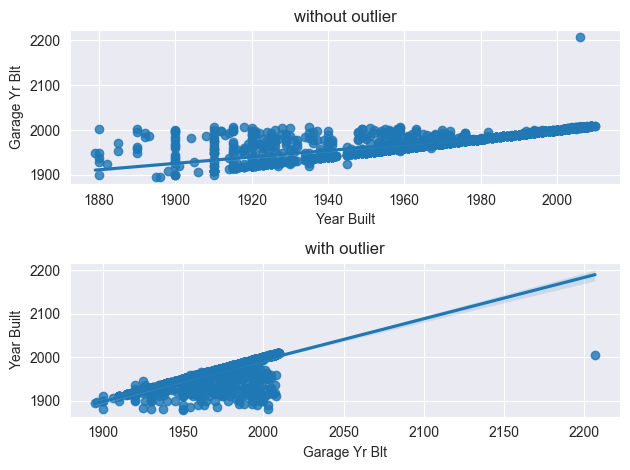

without outlier: 0.5162105956951499
with outlier 0.5162105956951499


In [267]:
#Garage Year Built, as a numerical, seems to have no smart way of imputing it - replacing with anything destroys the linear signal and correlation. 
#This same signal (of a missing garage) can be taken from any other garage related columns - the Garage Yr Blt feature will be dropped in the Data Pipeline
#df_train.head()

fig, axs = plt.subplots(2, 1)
sns.regplot(data=df_train, x='Year Built', y='Garage Yr Blt', ax=axs[0])
axs[0].set_title('without outlier')
sns.regplot(data=df_train, x='Garage Yr Blt', y='Year Built', ax=axs[1])
axs[1].set_title("with outlier")
plt.tight_layout()
plt.show()
print('without outlier:',df_train.corr(numeric_only=True)['Garage Yr Blt']['SalePrice'])
print('with outlier',df_train.corr(numeric_only=True)['Garage Yr Blt']['SalePrice'])

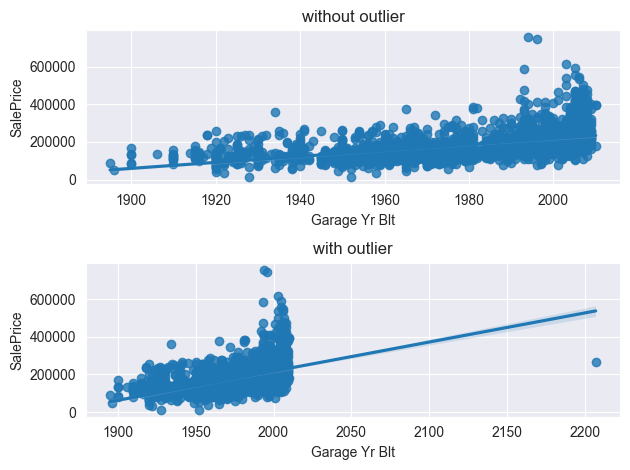

without outlier: 0.5213817724734765
with outlier 0.5162105956951499


In [268]:
#checking the impact of the incorrect entry in Garage Yr Blt (year 2207)

df_train_help = df_train[df_train['Garage Yr Blt'] <= 2010]
fig, axs = plt.subplots(2, 1)
sns.regplot(data=df_train_help, x='Garage Yr Blt', y='SalePrice', ax=axs[0])
axs[0].set_title('without outlier')
sns.regplot(data=df_train, x='Garage Yr Blt', y='SalePrice', ax=axs[1])
axs[1].set_title("with outlier")
plt.tight_layout()
plt.show()
print('without outlier:',df_train_help.corr(numeric_only=True)['Garage Yr Blt']['SalePrice'])
print('with outlier',df_train.corr(numeric_only=True)['Garage Yr Blt']['SalePrice'])

In [269]:
#pool quality is largely missing, let's see if it correlates with just not having a pool
print(len(df_train[df_train['Pool Area'] >= 1]))
#only 13 houses had a pool - that means that it must be those houses that have a reported pool quality. 
print(len(df_train[df_train['Pool QC'] != np.nan]))

12
2344


<Axes: xlabel='Pool QC', ylabel='SalePrice'>

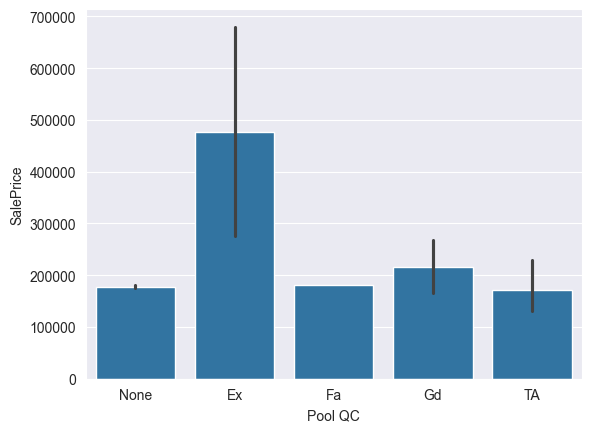

In [270]:
#pool quality appears to impact sales price
temp = df_train.copy()
temp['Pool QC'].fillna('None', inplace=True)
sns.barplot(data=temp, x='Pool QC', y='SalePrice')

In [271]:
#too little instances/data for generalization. 
temp['Pool QC'].value_counts()
#similar features will be collapsed into a binary existence feature

Pool QC
None    2332
Ex         4
Gd         4
TA         3
Fa         1
Name: count, dtype: int64

Mas Vnr Type
NaN        1775
BrkFace     880
Stone       249
BrkCmn       25
CBlock        1
Name: count, dtype: int64


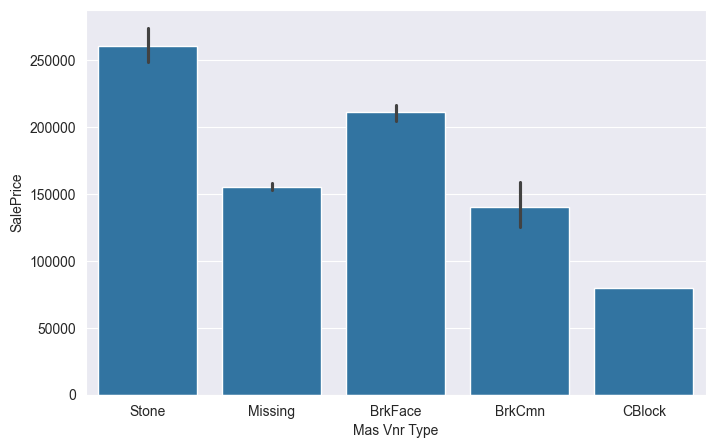

In [272]:
#masvnrtype?

tempor = df.copy()

tempor['Mas Vnr Type'] = tempor['Mas Vnr Type'].fillna('Missing')

# Now plot
plt.figure(figsize=(8,5))
sns.barplot(
    data=tempor, 
    x='Mas Vnr Type', 
    y='SalePrice', 
)

print(df['Mas Vnr Type'].value_counts(dropna=False))

<Axes: xlabel='Yr Sold', ylabel='SalePrice'>

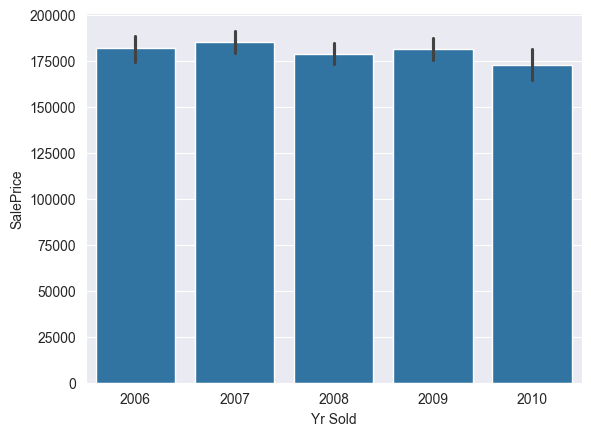

In [273]:
sns.barplot(data=df, x='Yr Sold', y='SalePrice', estimator='mean')

In [274]:
#checking how many rows are empty in all these fields at once.
df_train[df_train[['Garage Yr Blt', 'Garage Type', 'Garage Qual', 'Garage Cond', 'Garage Finish']].isna().all(axis=1)].shape
#so the 120 rows of missingness overlap - meaning these are simply houses without garages.


(120, 80)

In [275]:
#checking partial overlaps.
df_train[['Garage Yr Blt', 'Garage Type', 'Garage Qual', 'Garage Cond', 'Garage Finish']].isna().sum(axis=1).value_counts()

0    2222
5     120
4       2
Name: count, dtype: int64

In [276]:
#let's check the same thing with basements.
df[['Bsmt Exposure', 'BsmtFin Type 2', 'Bsmt Qual', 'Bsmt Cond', 'BsmtFin Type 1']].isna().sum(axis=1).value_counts()

0    2846
5      80
1       4
Name: count, dtype: int64

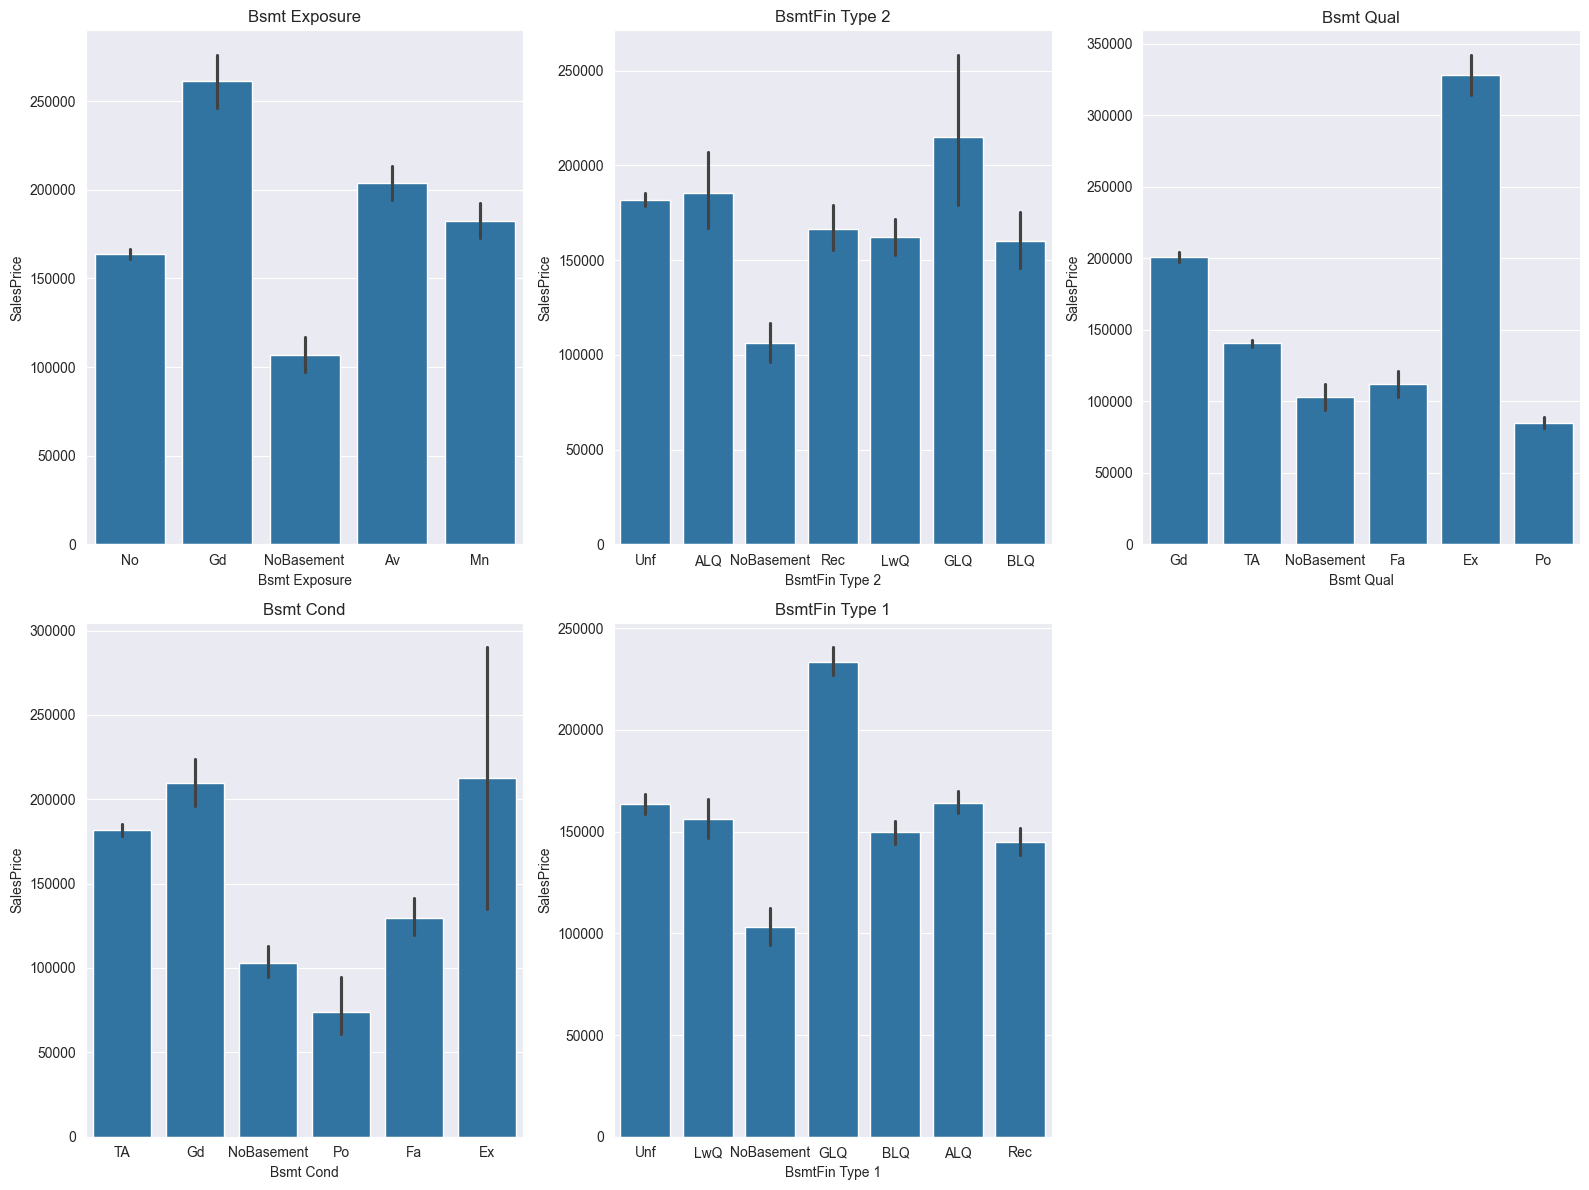

In [277]:
#let's vizualize the impact of various basement features on salepric

df_train_temp = df_train.copy()

bsmt_features = ['Bsmt Exposure', 'BsmtFin Type 2', 'Bsmt Qual', 'Bsmt Cond', 'BsmtFin Type 1']

for feature in bsmt_features:
    df_train_temp[feature].fillna('NoBasement', inplace=True)

plt.figure(figsize=(16,12))
for i, item in enumerate(bsmt_features, 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=df_train_temp, x=item, y='SalePrice')
    plt.title(f'{item}')
    plt.ylabel('SalesPrice')

plt.tight_layout()


### 3.2 Handling Missing Values - Pipeline??

- defining unique lists to be put into the data preprocessing pipeline

In [278]:
df_train.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Gara

In [279]:
df_train.dtypes

MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Alley               object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
BsmtFin SF 2       float64
Bsmt Unf SF        float64
T

In [280]:
#viewing all data types
for col in df_train.columns.tolist():
    if df[col].dtype == 'object':
        print(f"{col}")

pd.set_option('display.max_rows', 500)
#wrong: bsmt full and half bath.

MS Zoning
Street
Alley
Lot Shape
Land Contour
Utilities
Lot Config
Land Slope
Neighborhood
Condition 1
Condition 2
Bldg Type
House Style
Roof Style
Roof Matl
Exterior 1st
Exterior 2nd
Mas Vnr Type
Exter Qual
Exter Cond
Foundation
Bsmt Qual
Bsmt Cond
Bsmt Exposure
BsmtFin Type 1
BsmtFin Type 2
Heating
Heating QC
Central Air
Electrical
Kitchen Qual
Functional
Fireplace Qu
Garage Type
Garage Finish
Garage Qual
Garage Cond
Paved Drive
Pool QC
Fence
Misc Feature
Sale Type
Sale Condition


In [281]:
!pip install category_encoders

In [282]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder

#Different types of transforming we want to do:
#Numericals imputed with median
#Numericals imputed with 0
#Categoricals imputed with 0 and Ordinally Encoded
#Categoricals imputed with mode and ordianlly encoded
#Categoricals imputed with "missing" and one-hot encoded
#Categoricals imputed with mode and one-hot encoded
#Cateogricals Replaced with mode and Target Encoded

#high missingness features to be engineered into binary existence features should go into the one hot encoding set to fill with 
#Defining Separate lists to be transformed differently.

#Numerical Columns
num_cols = X_train.select_dtypes(exclude='object').columns.tolist()
#Categorical columns
categorical_columns = X_train.select_dtypes(include='object').columns.tolist()

#print(df_train.shape[1])
#print(len(num_cols))
#print(len(categorical_columns))

#1. Numericals Imputed with median list
num_median = ['Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Overall Qual', 'Overall Cond', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd']

#2. numericals imputed with 0 list
num_zero = list(set(num_cols) - set(num_median))

#print(num_zero)
#print(num_zero)
print(X_train.shape)
print(len(num_cols))
print(len(categorical_columns))
print()
print(len(num_median))
print(len(num_zero))



(2344, 79)
36
43

13
23


In [283]:
#Categoricals To Be Ordinally Encoded: 
cat_ordinal = ['Utilities', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Qual', 'Garage Cond']

#3. Categorials to be Target Encoded
cat_target = ['Neighborhood', 'Exterior 1st', 'Exterior 2nd', 'Sale Type']
df_train[categorical_columns].nunique().sort_values(ascending=False)

Neighborhood      28
Exterior 1st      16
Exterior 2nd      16
Sale Type         10
Condition 1        9
Functional         8
Condition 2        8
House Style        8
Roof Matl          8
MS Zoning          7
Garage Type        6
Heating            6
BsmtFin Type 2     6
BsmtFin Type 1     6
Foundation         6
Sale Condition     6
Roof Style         6
Lot Config         5
Garage Cond        5
Garage Qual        5
Fireplace Qu       5
Heating QC         5
Electrical         5
Bsmt Qual          5
Bldg Type          5
Bsmt Cond          5
Exter Cond         5
Misc Feature       4
Fence              4
Pool QC            4
Exter Qual         4
Bsmt Exposure      4
Land Contour       4
Kitchen Qual       4
Mas Vnr Type       4
Lot Shape          4
Land Slope         3
Garage Finish      3
Paved Drive        3
Utilities          3
Central Air        2
Street             2
Alley              2
dtype: int64

In [284]:
#Columns to be one hot encoded (nominal)
cat_onehot = list(set(categorical_columns) - set(cat_ordinal) - set(cat_target))

print(len(categorical_columns))
print(len(cat_onehot))
print(len(cat_ordinal))
print(len(cat_target))

print(categorical_columns)
print()
print('nominal:',sorted(cat_onehot))
print('ordinal',sorted(cat_ordinal))
print('target:',sorted(cat_target))

43
25
14
4
['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature', 'Sale Type', 'Sale Condition']

nominal: ['Alley', 'Bldg Type', 'Central Air', 'Condition 1', 'Condition 2', 'Electrical', 'Fence', 'Foundation', 'Garage Finish', 'Garage Type', 'Heating', 'House Style', 'Land Contour', 'Land Slope', 'Lot Config', 'Lot Shape', 'MS Zoning', 'Mas Vnr Type', 'Misc Feature', 'Paved Drive', 'Pool QC', 'Roof Matl', 'Roof Style', 'Sale Condition', 'Street']
ordinal ['Bsmt C

In [285]:
#4. Nominal columns to be imputed with "Missing":
cat_onehot_missing = ['Pool QC', 'Misc Feature', 'Alley', 'Garage Finish', 'Garage Type', 'Fence', 'Mas Vnr Type']
#5. Nominal columns to be imputed with mode
cat_onehot_mode = list(set(cat_onehot) - set(cat_onehot_missing))

print(len(cat_onehot))
print(len(cat_onehot_missing))
print(len(cat_onehot_mode))

25
7
18


In [286]:
#6. Ordinal columns to be imputed with "Missing" (signaling that the feature is missing): Bsmt Qual, Bsmt Cond, Bsmt Exposure, BsmtFin Type 1, BsmtFin Type 2, Fireplace Qu, Garage Qual, Garage Cond
cat_ordinal_missing = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Fireplace Qu', 'Garage Qual', 'Garage Cond']

#7. Ordinal columns to be imputed with mode: 
cat_ordinal_mode = list(set(cat_ordinal) - set(cat_ordinal_missing))

print(len(cat_ordinal))
print(len(cat_ordinal_missing))
print(len(cat_ordinal_mode))

14
8
6


In [287]:
#We now have 7 lists to be imputed and encoded in different ways. 
print("num_median:", len(num_median), num_median)
print("num_zero:", len(num_zero), num_zero)
print("cat_onehot_mode:", len(cat_onehot_mode), cat_onehot_mode)
print("cat_onehot_missing:", len(cat_onehot_missing), cat_onehot_missing)
print("cat_ordinal_mode:", len(cat_ordinal_mode), cat_ordinal_mode)
print("cat_ordinal_missing:", len(cat_ordinal_missing), cat_ordinal_missing)
print("cat_target:", len(cat_target), cat_target)

num_median: 13 ['Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Overall Qual', 'Overall Cond', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd']
num_zero: 23 ['Bsmt Unf SF', 'Mo Sold', 'Lot Frontage', 'Misc Val', 'Screen Porch', '3Ssn Porch', 'Fireplaces', 'Low Qual Fin SF', 'MS SubClass', 'Bsmt Half Bath', 'Yr Sold', 'Enclosed Porch', 'Lot Area', 'Garage Area', 'BsmtFin SF 1', 'Bsmt Full Bath', 'BsmtFin SF 2', 'Pool Area', 'Garage Cars', 'Open Porch SF', 'Mas Vnr Area', 'Wood Deck SF', 'Total Bsmt SF']
cat_onehot_mode: 18 ['Foundation', 'House Style', 'Condition 2', 'Roof Matl', 'Street', 'MS Zoning', 'Land Slope', 'Heating', 'Lot Shape', 'Sale Condition', 'Bldg Type', 'Roof Style', 'Lot Config', 'Land Contour', 'Paved Drive', 'Central Air', 'Condition 1', 'Electrical']
cat_onehot_missing: 7 ['Pool QC', 'Misc Feature', 'Alley', 'Garage Finish', 'Garage Type', 'Fence', 'Mas Vnr Type']
cat_ordinal_mode: 6 ['Kitchen 

In [288]:
#checking value ordering for columns to be imputed with mode:
print('Ordinal to be imputed with mode - list of values')
for feature in cat_ordinal_mode:
    print(f"{feature}:", X_train[feature].unique())

print()
print("Ordinal to be imputed with 'missing' - list of values")

for feature in cat_ordinal_missing:
    print(f"{feature}:", X_train[feature].unique())

Ordinal to be imputed with mode - list of values
Kitchen Qual: ['TA' 'Fa' 'Gd' 'Ex']
Exter Cond: ['TA' 'Gd' 'Fa' 'Ex' 'Po']
Heating QC: ['TA' 'Fa' 'Gd' 'Ex' 'Po']
Functional: ['Typ' 'Min2' 'Sev' 'Min1' 'Maj2' 'Mod' 'Maj1' 'Sal']
Utilities: ['AllPub' 'NoSewr' 'NoSeWa']
Exter Qual: ['TA' 'Fa' 'Gd' 'Ex']

Ordinal to be imputed with 'missing' - list of values
Bsmt Qual: ['Gd' 'TA' nan 'Fa' 'Ex' 'Po']
Bsmt Cond: ['TA' 'Gd' nan 'Po' 'Fa' 'Ex']
Bsmt Exposure: ['No' 'Gd' nan 'Av' 'Mn']
BsmtFin Type 1: ['Unf' 'LwQ' nan 'GLQ' 'BLQ' 'ALQ' 'Rec']
BsmtFin Type 2: ['Unf' 'ALQ' nan 'Rec' 'LwQ' 'GLQ' 'BLQ']
Fireplace Qu: ['TA' nan 'Ex' 'Po' 'Gd' 'Fa']
Garage Qual: ['TA' nan 'Gd' 'Fa' 'Po' 'Ex']
Garage Cond: ['TA' nan 'Gd' 'Fa' 'Po' 'Ex']


In [289]:
#defining lists in order:
#1. For Ordinal to be imputed with mode:
qualfeatures = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
utilities = ['ELO', 'NoSeWa', 'NoSewr', 'AllPub']
functional = ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal']
ordinal_mode_order = [qualfeatures,
                      qualfeatures,
                      qualfeatures,
                      qualfeatures,
                      utilities,
                      functional]

#2. For Ordinal to be imputed with missing
exposure = ['None', 'No', 'Mn', 'Av', 'Gd']
bsmtfin = ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
ordinal_missing_order = [qualfeatures,
                         qualfeatures,
                         exposure,
                         bsmtfin,
                         bsmtfin,
                         qualfeatures,
                         qualfeatures,
                         qualfeatures]

In [290]:
#Let's build a pipeline to handle this logic
#(we'll columns transform later, once features are enginnered and added to the list)

# 1. num_median: Impute with median, then scale
num_median_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. num_zero: Impute with 0, then scale
num_zero_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# 3. cat_onehot_mode: Impute with mode, then OneHotEncode
cat_onehot_mode_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='infrequent_if_exist',
                          min_frequency=30,
                          sparse_output=False))
])

# 4. cat_onehot_missing: Impute with constant 'Missing', then OneHotEncode
cat_onehot_missing_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', OneHotEncoder(handle_unknown='infrequent_if_exist',
                          min_frequency=30,
                          sparse_output=False))
])

# 5. cat_ordinal_mode: Impute with mode, then OrdinalEncode
cat_ordinal_mode_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('oe', OrdinalEncoder(
        categories=ordinal_mode_order,
        handle_unknown='use_encoded_value',
        unknown_value=-1 # Assign -1 to unknown categories
    ))
])

# 6. cat_ordinal_missing: Impute with constant 'None', then OrdinalEncode
cat_ordinal_missing_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('oe', OrdinalEncoder(
        categories=ordinal_missing_order,
        handle_unknown='use_encoded_value',
        unknown_value=-1 #Assigns -1 to unknown categories
    ))


])

target_transform_pipe = TargetEncoder(
    target_type='continuous', 
    cv=5,
    shuffle=True,
    random_state=42
)

#### FEATURE ENGINEERING PIPELINE. including:
- new features to create
- feature types to change (month sold into categorical, mssublass to categorical)
- turn high-missingness features into binary classifiers (impute missing with "Missing" - only that makes sense for the one hot transformer)
- drop garage year blt - no way to impute it functionally.
- remember to append the lists created for transformers with the correct newly engineered column names.
- performing custom imputations


In [291]:
X_train.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
381,20,RL,80.0,10400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,7,5,1976,1976,Gable,CompShg,HdBoard,HdBoard,BrkFace,189.0,TA,TA,CBlock,Gd,TA,No,Unf,0.0,Unf,0.0,1090.0,1090.0,GasA,TA,Y,SBrkr,1370,0,0,1370,0.0,0.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,479.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,6,2009,WD,Family
834,60,RL,NaN,28698,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,2Story,5,5,1967,1967,Flat,Tar&Grv,Plywood,Plywood,NaN,0.0,TA,TA,PConc,TA,Gd,Gd,LwQ,249.0,ALQ,764.0,0.0,1013.0,GasA,TA,Y,SBrkr,1160,966,0,2126,0.0,1.0,2,1,3,1,TA,7,Min2,0,NaN,Attchd,1967.0,Fin,2.0,538.0,TA,TA,Y,486,0,0,0,225,0,NaN,NaN,NaN,0,6,2009,WD,Abnorml
1898,90,RL,70.0,9842,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,Duplex,1Story,4,5,1962,1962,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,SBrkr,1224,0,0,1224,0.0,0.0,2,0,2,2,TA,6,Typ,0,NaN,CarPort,1962.0,Unf,2.0,462.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal
678,90,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,Duplex,1Story,4,5,1949,1950,Gable,CompShg,BrkFace,Stone,NaN,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,Fa,N,FuseF,1040,0,0,1040,0.0,0.0,2,0,2,2,TA,6,Typ,0,NaN,Detchd,1956.0,Unf,2.0,420.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
700,190,RM,63.0,7627,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Artery,Norm,2fmCon,2Story,4,6,1920,1950,Gable,CompShg,AsbShng,AsbShng,NaN,0.0,Fa,TA,BrkTil,Fa,Po,No,Unf,0.0,Unf,0.0,600.0,600.0,GasA,Gd,N,SBrkr,1101,600,0,1701,0.0,0.0,2,0,4,2,Fa,8,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,N,0,0,148,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal


In [292]:
#checking the skew of numerical variables
num_features = X_train.select_dtypes(exclude=object)
skew_num_features = num_features.skew()
print(skew_num_features)
skewed_features = skew_num_features[abs(skew_num_features) > 0.80]
skewed_features.index.to_list()

MS SubClass         1.364770
Lot Frontage        1.735006
Lot Area           13.743796
Overall Qual        0.204464
Overall Cond        0.595367
Year Built         -0.594285
Year Remod/Add     -0.428230
Mas Vnr Area        2.497916
BsmtFin SF 1        1.529633
BsmtFin SF 2        4.185302
Bsmt Unf SF         0.910201
Total Bsmt SF       1.343278
1st Flr SF          1.542293
2nd Flr SF          0.875991
Low Qual Fin SF    12.959105
Gr Liv Area         1.303483
Bsmt Full Bath      0.628831
Bsmt Half Bath      4.003080
Full Bath           0.184097
Half Bath           0.729985
Bedroom AbvGr       0.315893
Kitchen AbvGr       4.493078
TotRms AbvGrd       0.767736
Fireplaces          0.771836
Garage Yr Blt      -0.303852
Garage Cars        -0.211890
Garage Area         0.292990
Wood Deck SF        1.564691
Open Porch SF       2.664539
Enclosed Porch      3.993799
3Ssn Porch         12.140302
Screen Porch        3.894896
Pool Area          15.898588
Misc Val           20.416138
Mo Sold       

['MS SubClass',
 'Lot Frontage',
 'Lot Area',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Bsmt Half Bath',
 'Kitchen AbvGr',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val']

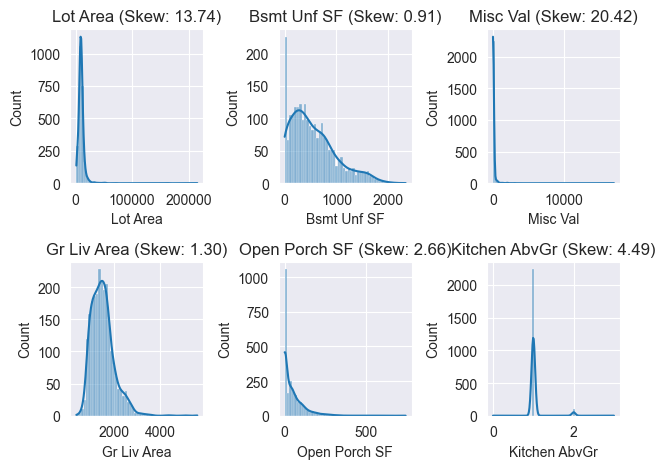

In [293]:
#vizualizing a few of the skewed features (BEFORE)
features_to_plot = [
    'Lot Area', 
    'Bsmt Unf SF',
    'Misc Val', 
    'Gr Liv Area', 
    'Open Porch SF', 
    'Kitchen AbvGr'
]

for i, feature in enumerate(features_to_plot):
    ax = plt.subplot(2, 3, i + 1) # <-- The fix
    sns.histplot(X_train[feature], bins=50, kde=True, ax=ax)
    ax.set_title(f'{feature} (Skew: {X_train[feature].skew():.2f})')

plt.tight_layout()

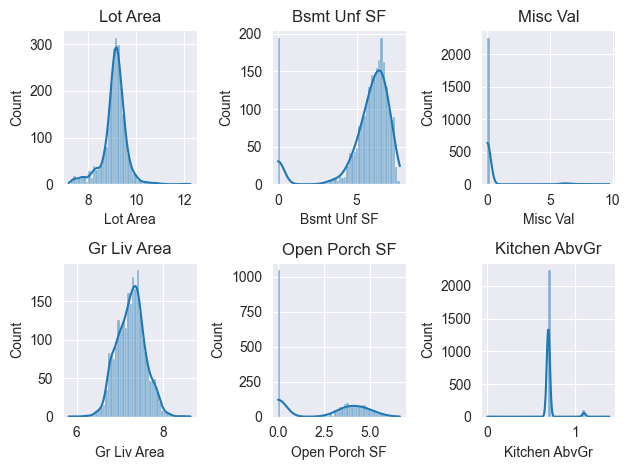

In [294]:
#AFTER (demo - there will be a systematic transformation proces for all features inside the pipeline later in the code)

for i, feature in enumerate(features_to_plot):
    ax = plt.subplot(2, 3, i + 1) # <-- The fix
    sns.histplot(np.log1p(X_train[feature]), bins=50, kde=True, ax=ax)
    ax.set_title(f'{feature}')

plt.tight_layout()

In [295]:
#defining a high-missingness list (including Mas Vnr Type and Fireplace Qu, since their missingness indicates lack of existence)
missingness = X_train.isna().sum().sort_values(ascending=False) * 100 / X_train.shape[0]
missingness

Pool QC            99.488055
Misc Feature       95.989761
Alley              93.088737
Fence              79.948805
Mas Vnr Type       60.836177
Fireplace Qu       48.805461
Lot Frontage       16.766212
Garage Yr Blt       5.204778
Garage Qual         5.204778
Garage Cond         5.204778
Garage Finish       5.204778
Garage Type         5.119454
Bsmt Exposure       2.687713
BsmtFin Type 2      2.645051
BsmtFin Type 1      2.602389
Bsmt Cond           2.602389
Bsmt Qual           2.602389
Mas Vnr Area        0.810580
Bsmt Full Bath      0.042662
BsmtFin SF 2        0.042662
Bsmt Unf SF         0.042662
Total Bsmt SF       0.042662
BsmtFin SF 1        0.042662
Bsmt Half Bath      0.042662
Garage Cars         0.042662
Garage Area         0.042662
Full Bath           0.000000
Half Bath           0.000000
Bedroom AbvGr       0.000000
Kitchen AbvGr       0.000000
Kitchen Qual        0.000000
TotRms AbvGrd       0.000000
Functional          0.000000
Sale Type           0.000000
Yr Sold       

In [296]:
high_missingness = missingness[missingness > 45]
high_missingness.index.to_list()

['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Mas Vnr Type', 'Fireplace Qu']

In [297]:
def FeatureEngineering(param):
    param_ = param.copy()

    #changing feature types
    param_['MS SubClass'] = param_['MS SubClass'].astype('object')
    param_['Mo Sold'] = param_['Mo Sold'].astype('object')

    #log transforming variables
    high_skew_features = ['Lot Frontage','Lot Area','Mas Vnr Area',
    'BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','1st Flr SF',
    '2nd Flr SF','Low Qual Fin SF','Gr Liv Area','Bsmt Half Bath','Kitchen AbvGr',
    'Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch',
    'Pool Area','Misc Val']

    for item in high_skew_features:
        param_[item] = np.log1p(param_[item])

    #turning high-missingness features into binaries
    high_missingness_list = ['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Mas Vnr Type', 'Fireplace Qu']

    for item in high_missingness_list:
        param_[item] = param_[item].notna().astype(int) 

    #creating variables through interaction terms
    param_['TotalSF'] = param_['Total Bsmt SF'] + param_['1st Flr SF'] + param_['2nd Flr SF']
    param_['AgeAtSale'] = param_['Yr Sold'] - param_['Year Built']
    param_['TimeSinceRemod'] = param_['Yr Sold'] - param_['Year Remod/Add']
    param_['TotalBathrooms'] = (param_['Full Bath'] + 0.5*param_['Half Bath'] +
                                param_['Bsmt Full Bath'] + 0.5*param_['Bsmt Half Bath'])

    #defining new binaries
    param_['HasGarage'] = (param_['Garage Area'] > 0).astype(int)
    param_['Has2ndFloor'] = (param_['2nd Flr SF'] > 0).astype(int)
    param_['WasRemodeled'] = (param_['Year Remod/Add'] != param_['Year Built']).astype(int)

    #dropping unusable features
    param_ = param_.drop('Garage Yr Blt', axis=1)

    return param_

In [298]:
#extending our lists by the newly created features
new_numeric_median = ['TotalSF', 'AgeAtSale', 'TimeSinceRemod', 'TotalBathrooms']
num_median.extend(new_numeric_median)

#we won't append the newly created binaries, since they are ready to use and don't need encoding/imputing

#removing the dropped Garage Yr Blt feature from its list
num_median.remove('Garage Yr Blt')

#the following are now cateogircals
changed_types = ['MS SubClass', 'Mo Sold']
for feat in changed_types:
    num_zero.remove(feat)
    cat_onehot_mode.append(feat)

In [299]:
#using a function transformer to turn this function into a pipeline step
from sklearn.preprocessing import FunctionTransformer

feature_transformer = FunctionTransformer(FeatureEngineering, validate=False)

In [300]:
#using column transformer to synthesize the preprocessing step:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_median', num_median_pipe, num_median),
        ('num_zero', num_zero_pipe, num_zero),
        ('cat_ohe_mode', cat_onehot_mode_pipe, cat_onehot),
        ('cat_ohe_miss', cat_onehot_missing_pipe, cat_onehot_missing),
        ('cat_ord_mode', cat_ordinal_mode_pipe, cat_ordinal_mode),
        ('cat_ord_miss', cat_ordinal_missing_pipe, cat_ordinal_missing),
        ('cat_target', target_transform_pipe, cat_target)

    ],
    remainder='passthrough'
)

In [301]:
#combining pipelines
preprocessing_pipeline = Pipeline(steps=[
    ('feature_transformer', feature_transformer),
    ('preprocessor', preprocessor),
])

In [302]:
#ensuring the pipeline works as intended
preprocessing_pipeline.set_output(transform="pandas")

,steps,"[('feature_transformer', ...), ('preprocessor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,func,<function Fea...t 0x1686f6160>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


## INSIGHTFUL EDA:
- plotting useful stuff

### How does location impact sale price?

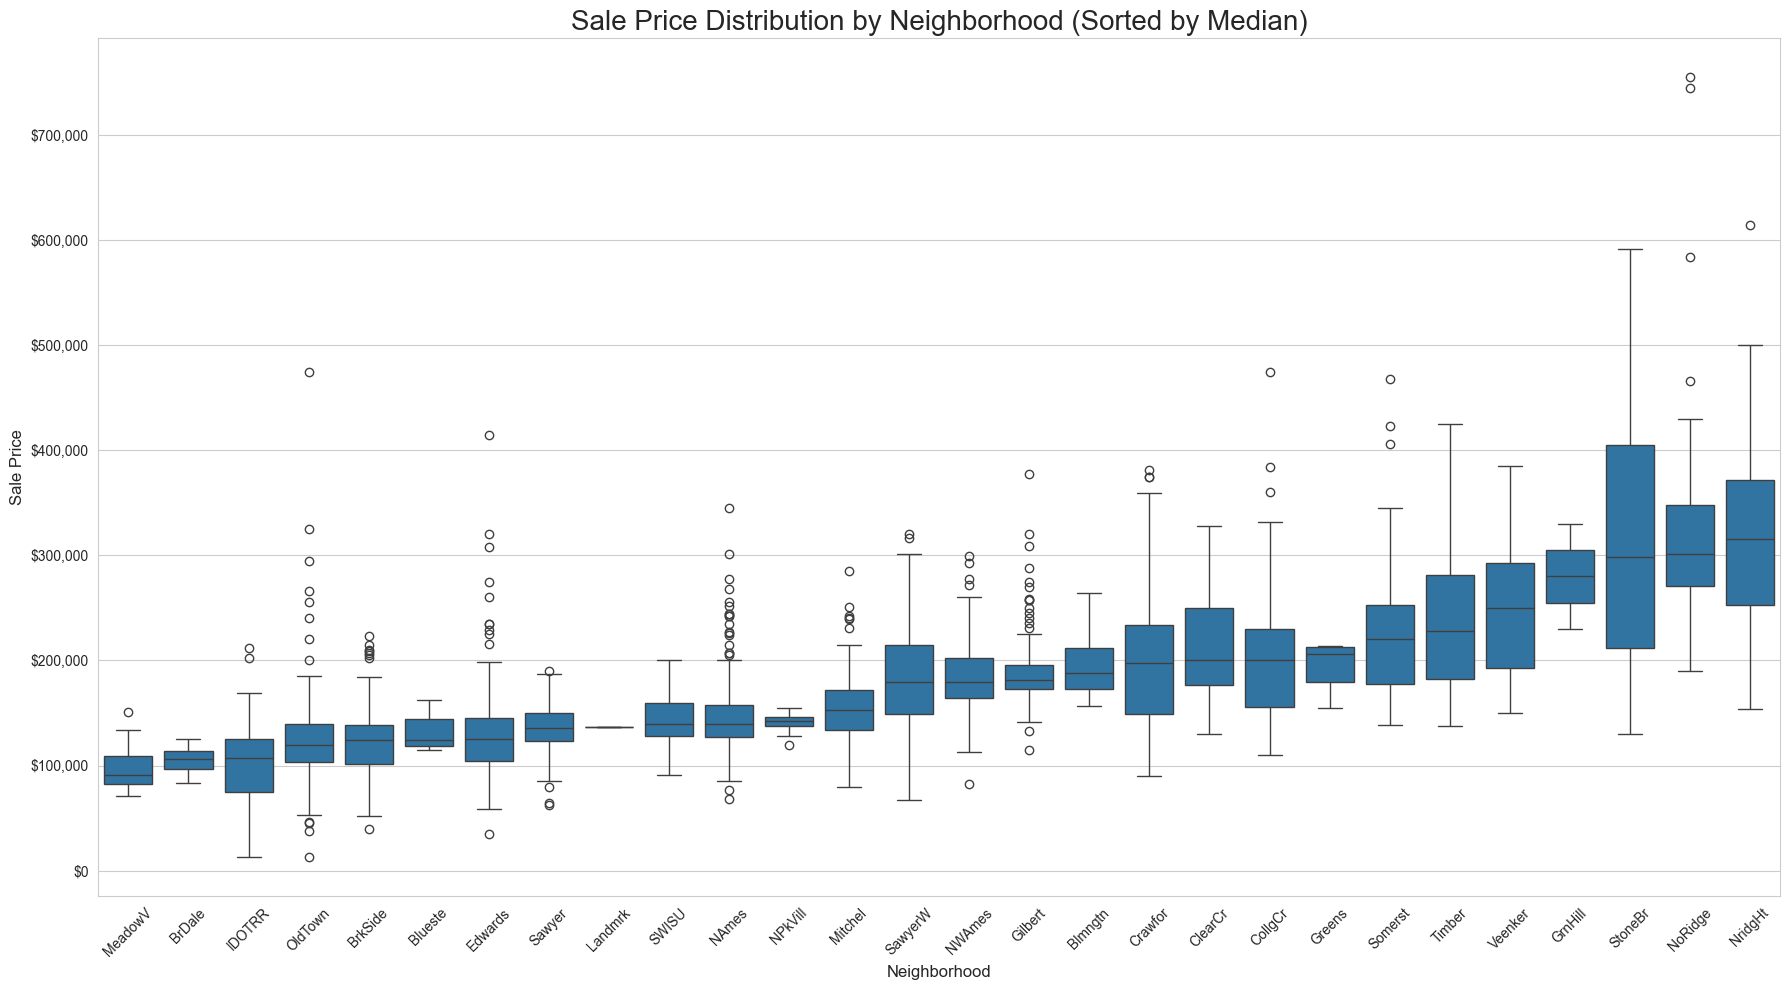

In [303]:
#sns.set_style("whitegrid")
from matplotlib.ticker import StrMethodFormatter

sns.set_style('whitegrid')

plt.figure(figsize=(18, 10))

#define order
median_prices = df_train.groupby('Neighborhood')['SalePrice'].median().sort_values()
sorted_neighborhood_list = median_prices.index

#plot
ax = sns.boxplot(
    x='Neighborhood', 
    y='SalePrice', 
    data=df_train, 
    order=sorted_neighborhood_list
)

#display $
formatter = StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(formatter)

#titles and labels
ax.set_title('Sale Price Distribution by Neighborhood (Sorted by Median)', fontsize=20)

ax.set_ylabel('Sale Price', fontsize=12)
ax.set_xlabel('Neighborhood', fontsize=12)

plt.xticks(rotation=45)

plt.tight_layout()


Neighborhood has a huge impact on sale price, with neighborhoods like Meadow Village and Briardale averaging a $100k sale price, while Northridge and Northridge Heights average $300k

### How has the market changed year-to-year?

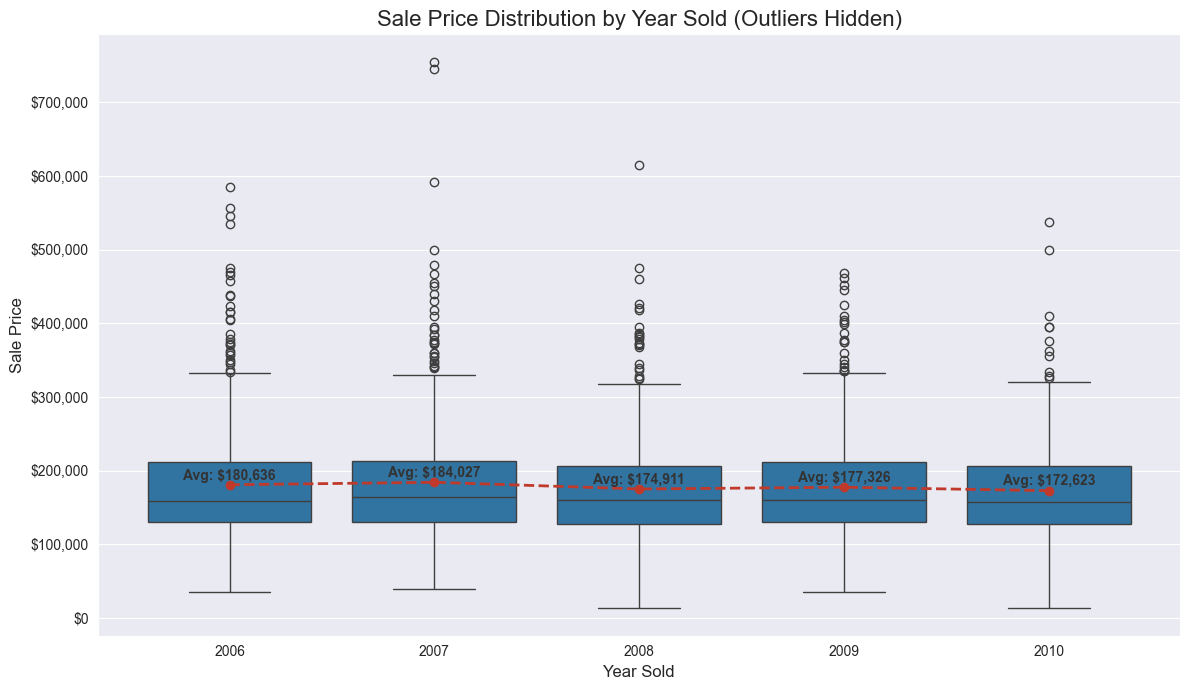

In [304]:
sns.set_style("darkgrid")

plt.figure(figsize=(12, 7))

ax = sns.boxplot(
    x='Yr Sold', 
    y='SalePrice', 
    data=df_train,
)

mean_prices = df_train.groupby('Yr Sold')['SalePrice'].mean()

tick_locs = ax.get_xticks()

ax.plot(
    ax.get_xticks(), 
    mean_prices,
    color='#c0392b',
    marker='o',    
    linestyle='--',
    linewidth=2
)

for i, year in enumerate(mean_prices.index):
    
    mean_val = mean_prices.loc[year]
    
    ax.text(
        x=i,
        y=mean_val + 3000,
        s=f'Avg: ${mean_val:,.0f}',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold',
        color='#333333'
    )

formatter = StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(formatter)

# Set clean title and labels
ax.set_title('Sale Price Distribution by Year Sold (Outliers Hidden)', fontsize=16)
ax.set_ylabel('Sale Price', fontsize=12)
ax.set_xlabel('Year Sold', fontsize=12)

# 5. Show the plot
plt.tight_layout()
plt.show()



Surprisingly, the average sale price barely moved in Ames between 2007 and 2009. This suggests the local market was highly insulated from the national crash - despite national panic, Ames had local stability.

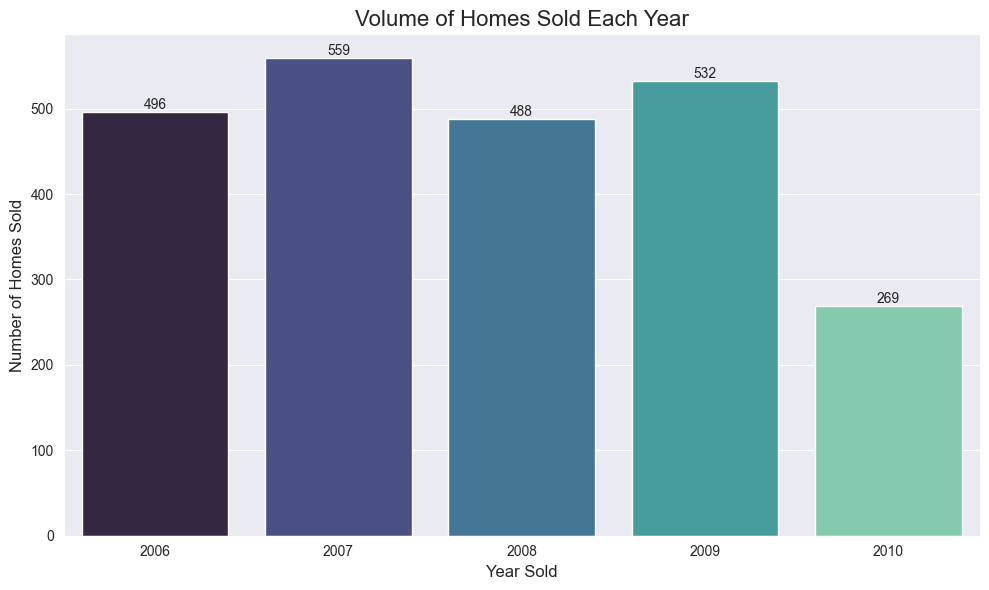

In [305]:
sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))

ax = sns.countplot(
    x='Yr Sold', 
    data=df_train,
    palette='mako'
)

for container in ax.containers:
    ax.bar_label(container, fontsize=10)

ax.set_title('Volume of Homes Sold Each Year', fontsize=16)
ax.set_ylabel('Number of Homes Sold', fontsize=12)
ax.set_xlabel('Year Sold', fontsize=12)

ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ','))
)

# 6. Show the plot
plt.tight_layout()
plt.show()

The crash of 2008 did negatively impact the amount of homes sold in Ames in 2008 however, dropping by close to 15%. The great decrease in demand is alarming in 2010 however, though this could be due to a data collection cutoff.

### How much resale value do renovations actually bring?

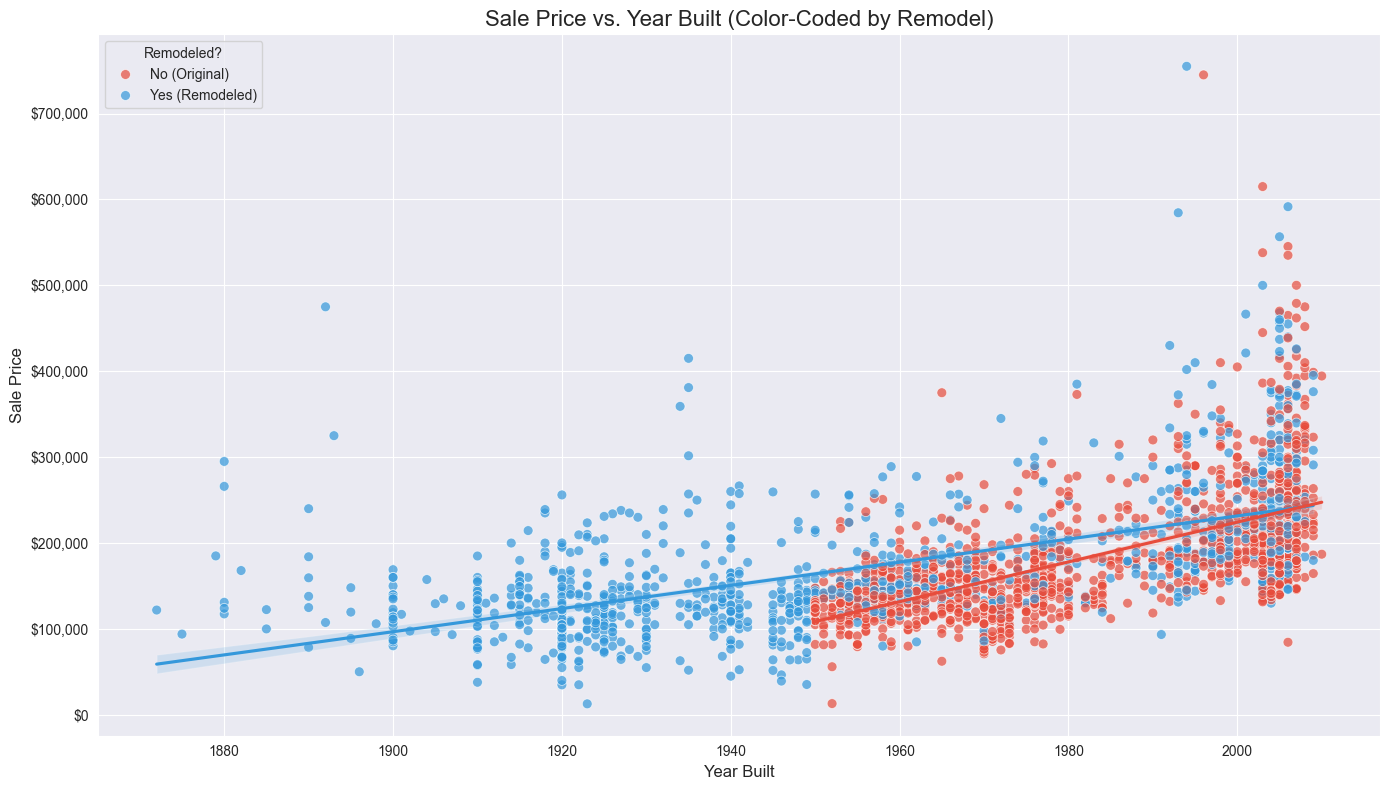

In [306]:
df_viz = df_train.copy()

df_viz['AgeAtSale'] = df_viz['Yr Sold'] - df_viz['Year Built']
df_viz['TimeSinceRemod'] = df_viz['Yr Sold'] - df_viz['Year Remod/Add']

df_viz['Was Remodeled'] = np.where(
    df_viz['TimeSinceRemod'] < df_viz['AgeAtSale'], 
    'Yes (Remodeled)', 
    'No (Original)'
)

sns.set_style("darkgrid")
plt.figure(figsize=(14, 8))

ax = sns.scatterplot(
    x='Year Built',
    y='SalePrice',
    data=df_viz,
    hue='Was Remodeled',  
    palette={'Yes (Remodeled)': '#3498db', 'No (Original)': '#e74c3c'},
    alpha=0.7,
    s=50
)

sns.regplot(
    x='Year Built', y='SalePrice', data=df_viz[df_viz['Was Remodeled'] == 'Yes (Remodeled)'],
    scatter=False, ax=ax, label=None, color='#3498db'
)
sns.regplot(
    x='Year Built', y='SalePrice', data=df_viz[df_viz['Was Remodeled'] == 'No (Original)'],
    scatter=False, ax=ax, label=None, color='#e74c3c'
)

formatter = StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(formatter)

ax.set_title('Sale Price vs. Year Built (Color-Coded by Remodel)', fontsize=16)
ax.set_ylabel('Sale Price', fontsize=12)
ax.set_xlabel('Year Built', fontsize=12)

ax.legend(title='Remodeled?', loc='upper left')

plt.tight_layout()
plt.show()

The value of remodeling depends entirely on the home's age. Our analysis shows remodeling is an essential price stabilizer for pre-1960s homes, allowing them to compete with newer properties. However, for homes built after 1990, the price returns on a major remodel are minimal, suggesting agents should advise clients to prioritize staging and curb appeal instead.

### Quantifying the value of key features

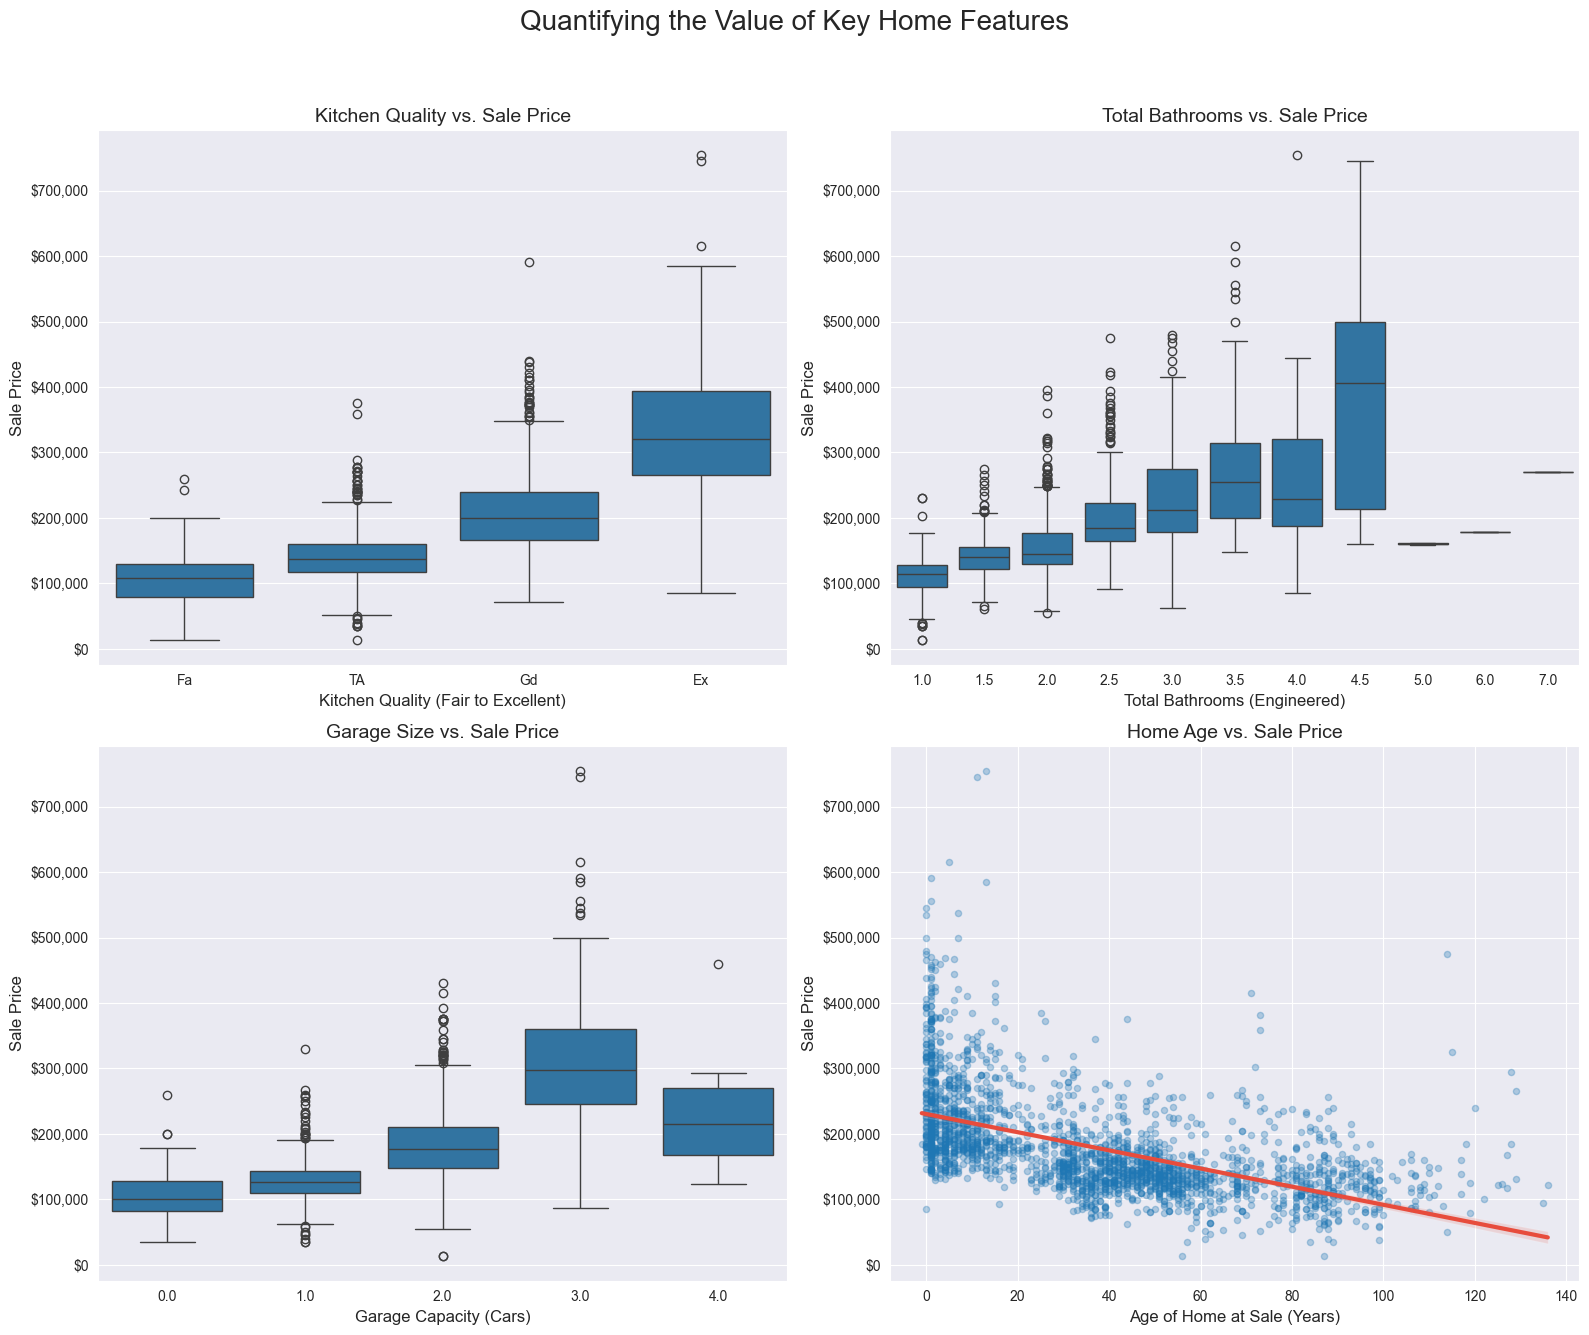

In [307]:
df_viz = df_train.copy()

# Engineer TotalBathrooms
df_viz['TotalBathrooms'] = (df_viz['Full Bath'] + 0.5*df_viz['Half Bath'] + 
                            df_viz['Bsmt Full Bath'] + 0.5*df_viz['Bsmt Half Bath'])

# Engineer AgeAtSale
df_viz['AgeAtSale'] = df_viz['Yr Sold'] - df_viz['Year Built']


# --- 2. Set up the 2x2 Subplot Grid ---
sns.set_style("darkgrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle("Quantifying the Value of Key Home Features", fontsize=20)


# --- 3. Plot 1: Kitchen Quality (Boxplot) ---
# We define the correct logical order for quality
kitchen_order = ['Fa', 'TA', 'Gd', 'Ex'] 
ax1 = axes[0, 0]
sns.boxplot(
    x='Kitchen Qual',
    y='SalePrice',
    data=df_viz,
    order=kitchen_order,
    ax=ax1
)
ax1.set_title('Kitchen Quality vs. Sale Price', fontsize=14)
ax1.set_xlabel('Kitchen Quality (Fair to Excellent)', fontsize=12)


# --- 4. Plot 2: Total Bathrooms (Boxplot) ---
ax2 = axes[0, 1]
sns.boxplot(
    x='TotalBathrooms',
    y='SalePrice',
    data=df_viz,
    ax=ax2
)
ax2.set_title('Total Bathrooms vs. Sale Price', fontsize=14)
ax2.set_xlabel('Total Bathrooms (Engineered)', fontsize=12)


# --- 5. Plot 3: Garage Cars (Boxplot) ---
ax3 = axes[1, 0]
sns.boxplot(
    x='Garage Cars',  # Note: This might be 'GarageCars' (no space)
    y='SalePrice',
    data=df_viz,
    ax=ax3
)
ax3.set_title('Garage Size vs. Sale Price', fontsize=14)
ax3.set_xlabel('Garage Capacity (Cars)', fontsize=12)


# --- 6. Plot 4: Age at Sale (Scatter/Regplot) ---
# A scatter plot with a regression line is better for a continuous feature
ax4 = axes[1, 1]
sns.regplot(
    x='AgeAtSale',
    y='SalePrice',
    data=df_viz,
    ax=ax4,
    scatter_kws={'alpha': 0.3, 's': 20}, # Make scatter points light
    line_kws={'color': '#e74c3c', 'linewidth': 3} # Make line strong red
)
ax4.set_title('Home Age vs. Sale Price', fontsize=14)
ax4.set_xlabel('Age of Home at Sale (Years)', fontsize=12)


# --- 7. Final Polish (Apply to all axes) ---
formatter = StrMethodFormatter('${x:,.0f}')
for ax in axes.flat:
    ax.yaxis.set_major_formatter(formatter)
    ax.set_ylabel('Sale Price', fontsize=12) # Set all Y-labels at once

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Make room for the main title
plt.show()

- an excellent kitchen quality is correlated with a $100k increase in house value
- the total amount of bathrooms also highly impacts sale price (the more the better)
- the size of the garage also represents a positive correlation with the target (the lower value for 4-car garages can be explained by too little instances of that case - only 13 garages in our training set have space for 4 garages)
- the younger the home, the higher the average saleprice

### Is sale price seasonal?

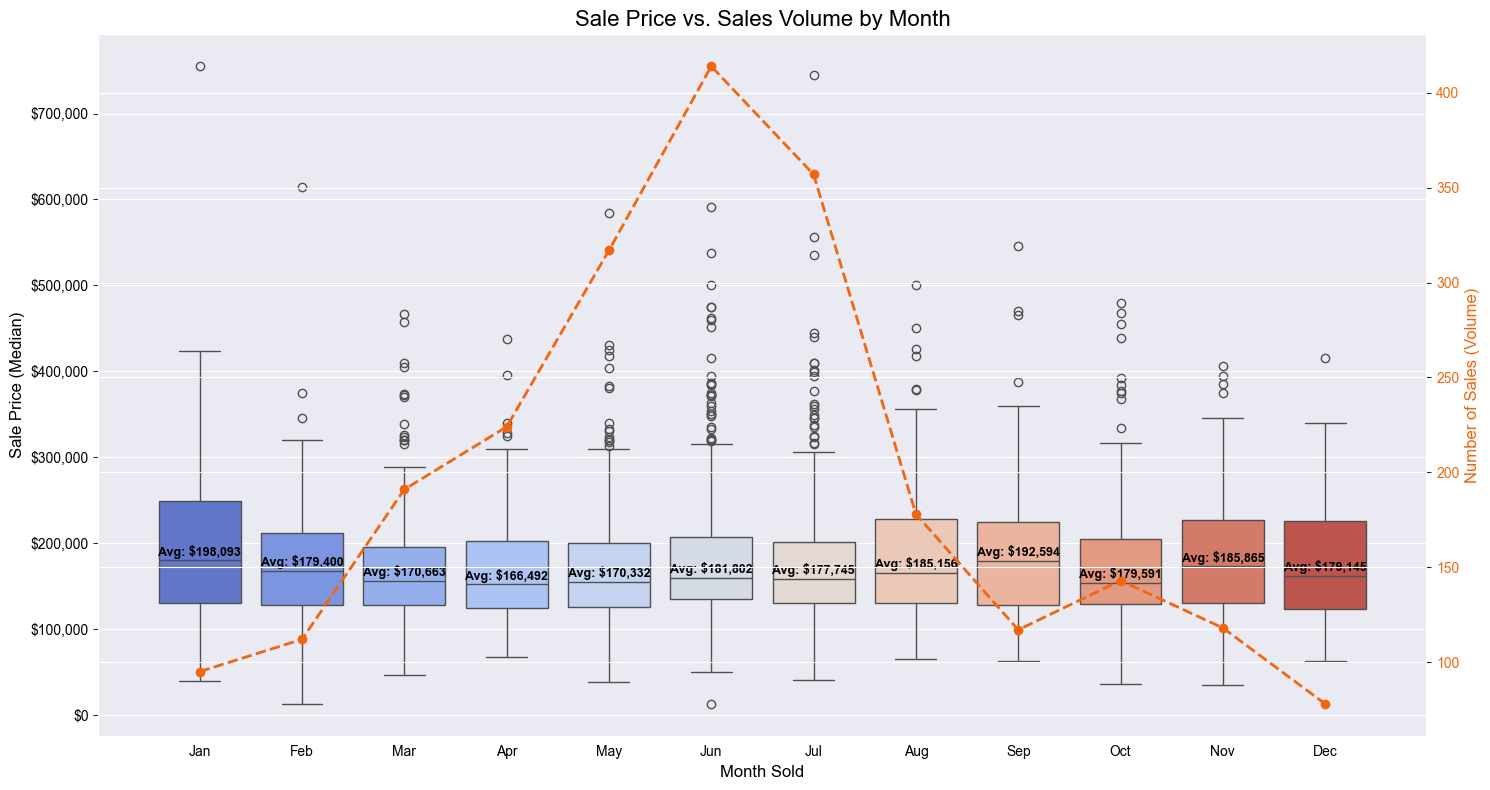

In [308]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15, 8)) # Use plt.subplots to get ax directly

# --- 1. Map Month Numbers to Names for Readability ---
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
# Create a temporary column with the month names
df_viz = df_train.copy()
df_viz['Month'] = df_viz['Mo Sold'].map(month_map)

# Define the correct order for the x-axis
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

mean_prices = df_viz.groupby('Month')['SalePrice'].mean().reindex(month_order)
# --- 2. Plot the Boxplot on the Left Axis (ax) ---
sns.boxplot(
    x='Month', 
    y='SalePrice', 
    data=df_viz, 
    order=month_order,
    ax=ax,
    palette='coolwarm'
)

# --- 3. Format the Left Axis (Sale Price) ---
formatter = StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel('Sale Price (Median)', fontsize=12, color='black')
ax.set_xlabel('Month Sold', fontsize=12, color='black')
ax.set_title('Sale Price vs. Sales Volume by Month', fontsize=16, color='black')
ax.tick_params(axis='y', labelcolor='black')
ax.tick_params(axis='x', labelcolor='black')


# --- 4. Create the Second Axis (ax2) for Volume ---
ax2 = ax.twinx()  # <-- This is the key line

# --- 5. Calculate and Plot the Volume Line ---
# Get the count of sales, and re-index it to be in the correct month order
sales_counts = df_viz['Month'].value_counts().reindex(month_order)

q3 = df_viz.groupby('Month')['SalePrice'].quantile(0.50)
position = (q3).reindex(month_order)

# Ensure the whisker doesn't go past the actual max data point
max_prices = df_viz.groupby('Month')['SalePrice'].max().reindex(month_order)
upper_whisker = pd.DataFrame({'position': position, 'max': max_prices}).min(axis=1)

for i, month in enumerate(month_order):
    mean_val = mean_prices.loc[month]
    text_y_pos = position.loc[month] + 2000

    ax.text(
        x=i,
        y=text_y_pos,
        s=f'Avg: ${mean_val:,.0f}',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold',
        color='black' # Using black as per your style
    )
ax2.plot(
    sales_counts.index, 
    sales_counts.values,
    color="#f1660f",  # A bright yellow
    marker='o',
    linestyle='--',
    linewidth=2,
    label='Sales Volume'
)

# --- 6. Format the Right Axis (Volume) ---
ax2.set_ylabel('Number of Sales (Volume)', fontsize=12, color='#f1660f')
ax2.tick_params(axis='y', labelcolor='#f1660f')

plt.tight_layout()
plt.show()

In terms of price, we can see a slight trend of price increasing closer to the end of the year (excluding December - potentially due to Christman)

However, demand is clearly cyclical, being 400% higher in the summer months as opposed to the winter months.

### Overall Quality as a clear predictor of sale price

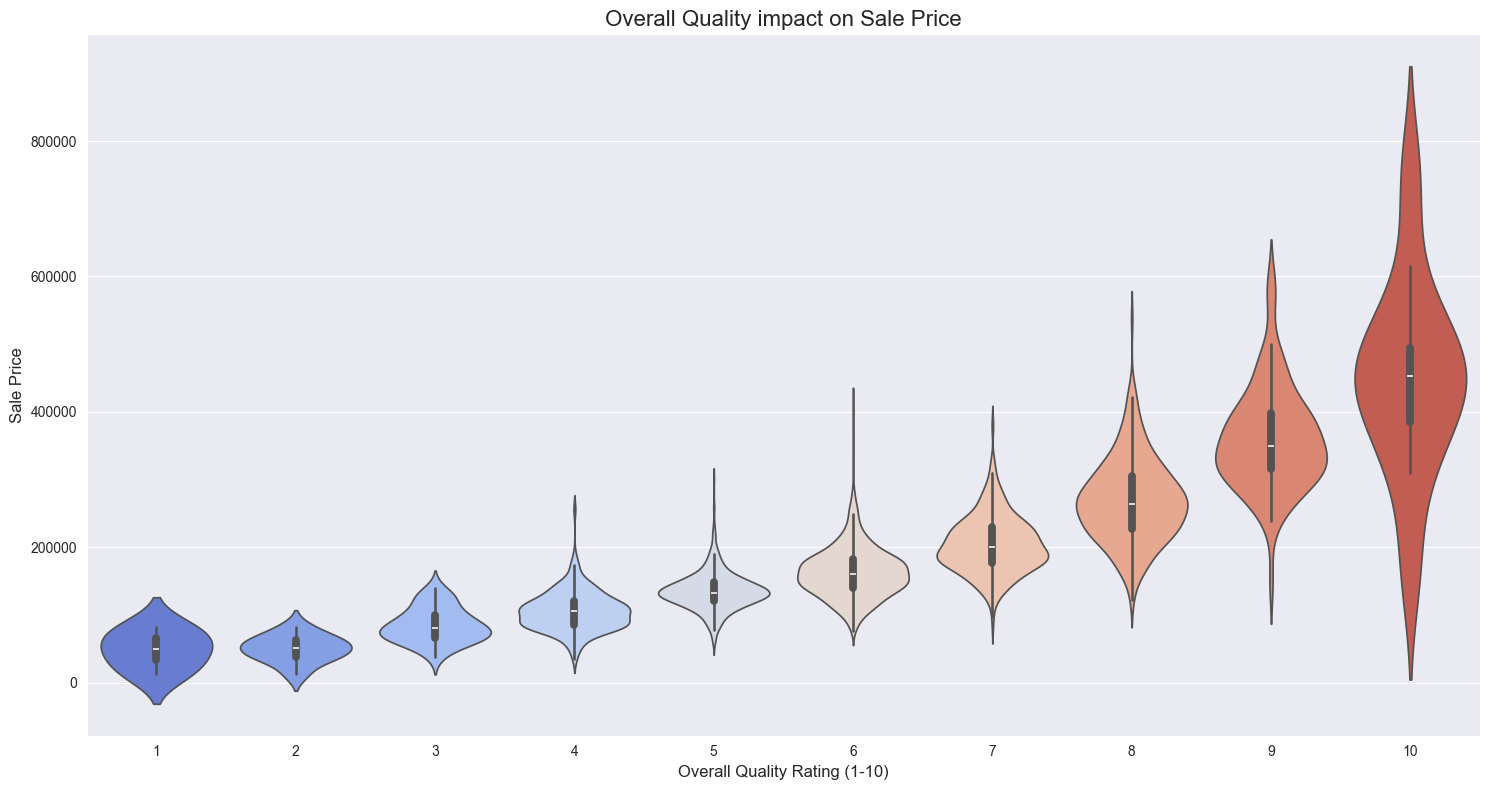

In [309]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.violinplot(
    x='Overall Qual',
    y='SalePrice',
    data=df_train,
    palette='coolwarm',
    ax=ax
)

ax.set_title('Overall Quality impact on Sale Price', fontsize=16)
ax.set_ylabel('Sale Price', fontsize=12)
ax.set_xlabel('Overall Quality Rating (1-10)', fontsize=12)

# 5. Show the plot
plt.tight_layout()
plt.show()

The data shows a clear premium on 'Very Good' homes (8+). While the correlation between quality and price is strong across the board, the most significant price increase occurs when moving a property from the Good (6-7) to Very Good (8+) tier. This indicates that major, high-quality renovations designed to push a house into the 8+ rating will likely yield the highest return on investment.

In [310]:
## Modeling

#running the preprocessing pipeline

X_train_prepared = preprocessing_pipeline.fit_transform(X_train, y_train_log)


X_test_prepared = preprocessing_pipeline.transform(X_test)

print(f"Original shape: {X_train.shape}")
print(f"Prepared shape: {X_train_prepared.shape}")

Original shape: (2344, 79)
Prepared shape: (2344, 164)


In [311]:
X_train_prepared.head()

,num_median__Year Built,num_median__Year Remod/Add,num_median__Overall Qual,num_median__Overall Cond,num_median__1st Flr SF,num_median__2nd Flr SF,num_median__Gr Liv Area,num_median__Full Bath,num_median__Half Bath,num_median__Bedroom AbvGr,num_median__Kitchen AbvGr,num_median__TotRms AbvGrd,num_median__TotalSF,num_median__AgeAtSale,num_median__TimeSinceRemod,num_median__TotalBathrooms,num_zero__Bsmt Unf SF,num_zero__Lot Frontage,num_zero__Misc Val,num_zero__Screen Porch,num_zero__3Ssn Porch,num_zero__Fireplaces,num_zero__Low Qual Fin SF,num_zero__Bsmt Half Bath,num_zero__Yr Sold,num_zero__Enclosed Porch,num_zero__Lot Area,num_zero__Garage Area,num_zero__BsmtFin SF 1,num_zero__Bsmt Full Bath,num_zero__BsmtFin SF 2,num_zero__Pool Area,num_zero__Garage Cars,num_zero__Open Porch SF,num_zero__Mas Vnr Area,num_zero__Wood Deck SF,num_zero__Total Bsmt SF,cat_ohe_mode__Garage Type_Attchd,cat_ohe_mode__Garage Type_Basment,cat_ohe_mode__Garage Type_BuiltIn,cat_ohe_mode__Garage Type_Detchd,cat_ohe_mode__Garage Type_infrequent_sklearn,cat_ohe_mode__Roof Matl_CompShg,cat_ohe_mode__Roof Matl_infrequent_sklearn,cat_ohe_mode__Street_Pave,cat_ohe_mode__Street_infrequent_sklearn,cat_ohe_mode__Land Slope_Gtl,cat_ohe_mode__Land Slope_Mod,cat_ohe_mode__Land Slope_infrequent_sklearn,cat_ohe_mode__Heating_GasA,cat_ohe_mode__Heating_infrequent_sklearn,cat_ohe_mode__Lot Shape_IR1,cat_ohe_mode__Lot Shape_IR2,cat_ohe_mode__Lot Shape_Reg,cat_ohe_mode__Lot Shape_infrequent_sklearn,cat_ohe_mode__Mas Vnr Type_0,cat_ohe_mode__Mas Vnr Type_1,cat_ohe_mode__Central Air_N,cat_ohe_mode__Central Air_Y,cat_ohe_mode__Electrical_FuseA,cat_ohe_mode__Electrical_FuseF,cat_ohe_mode__Electrical_SBrkr,cat_ohe_mode__Electrical_infrequent_sklearn,cat_ohe_mode__Alley_0,cat_ohe_mode__Alley_1,cat_ohe_mode__Foundation_BrkTil,cat_ohe_mode__Foundation_CBlock,cat_ohe_mode__Foundation_PConc,cat_ohe_mode__Foundation_Slab,cat_ohe_mode__Foundation_infrequent_sklearn,cat_ohe_mode__House Style_1.5Fin,cat_ohe_mode__House Style_1Story,cat_ohe_mode__House Style_2Story,cat_ohe_mode__House Style_SFoyer,cat_ohe_mode__House Style_SLvl,cat_ohe_mode__House Style_infrequent_sklearn,cat_ohe_mode__Condition 2_Norm,cat_ohe_mode__Condition 2_infrequent_sklearn,cat_ohe_mode__MS Zoning_FV,cat_ohe_mode__MS Zoning_RL,cat_ohe_mode__MS Zoning_RM,cat_ohe_mode__MS Zoning_infrequent_sklearn,cat_ohe_mode__Garage Finish_Fin,cat_ohe_mode__Garage Finish_RFn,cat_ohe_mode__Garage Finish_Unf,cat_ohe_mode__Land Contour_Bnk,cat_ohe_mode__Land Contour_HLS,cat_ohe_mode__Land Contour_Low,cat_ohe_mode__Land Contour_Lvl,cat_ohe_mode__Fence_0,cat_ohe_mode__Fence_1,cat_ohe_mode__Sale Condition_Abnorml,cat_ohe_mode__Sale Condition_Family,cat_ohe_mode__Sale Condition_Normal,cat_ohe_mode__Sale Condition_Partial,cat_ohe_mode__Sale Condition_infrequent_sklearn,cat_ohe_mode__Misc Feature_0,cat_ohe_mode__Misc Feature_1,cat_ohe_mode__Bldg Type_1Fam,cat_ohe_mode__Bldg Type_2fmCon,cat_ohe_mode__Bldg Type_Duplex,cat_ohe_mode__Bldg Type_Twnhs,cat_ohe_mode__Bldg Type_TwnhsE,cat_ohe_mode__Roof Style_Gable,cat_ohe_mode__Roof Style_Hip,cat_ohe_mode__Roof Style_infrequent_sklearn,cat_ohe_mode__Lot Config_Corner,cat_ohe_mode__Lot Config_CulDSac,cat_ohe_mode__Lot Config_FR2,cat_ohe_mode__Lot Config_Inside,cat_ohe_mode__Lot Config_infrequent_sklearn,cat_ohe_mode__Pool QC_0,cat_ohe_mode__Pool QC_infrequent_sklearn,cat_ohe_mode__Paved Drive_N,cat_ohe_mode__Paved Drive_P,cat_ohe_mode__Paved Drive_Y,cat_ohe_mode__Condition 1_Artery,cat_ohe_mode__Condition 1_Feedr,cat_ohe_mode__Condition 1_Norm,cat_ohe_mode__Condition 1_RRAn,cat_ohe_mode__Condition 1_infrequent_sklearn,cat_ohe_miss__Pool QC_0,cat_ohe_miss__Pool QC_infrequent_sklearn,cat_ohe_miss__Misc Feature_0,cat_ohe_miss__Misc Feature_1,cat_ohe_miss__Alley_0,cat_ohe_miss__Alley_1,cat_ohe_miss__Garage Finish_Fin,cat_ohe_miss__Garage Finish_Missing,cat_ohe_miss__Garage Finish_RFn,cat_ohe_miss__Garage Finish_Unf,cat_ohe_miss__Garage Type_Attchd,cat_ohe_miss__Garage Type_Basment,cat_ohe_miss__Garage T

### 3.3 Baseline Model

In [312]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

mean = y_train.mean()
y_pred = [mean] * len(y_test)
print(len(y_pred))

r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Baseline model r2:', r2)
print('Baseline model root mean squared error', rmse)

586
Baseline model r2: -0.015282546687198861
Baseline model root mean squared error 90222.37239996913
